### Unidad II. Regresiones y reducción de dimensionalidad.

## Análisis de varianza unifactorial y multifactorial.

- El análisis de varianza unifactorial paramétrico. Hipótesis necesaria.
 - Análisis de la varianza (ANOVA)
- Complementos del análisis unifactorial. Los tests de rangos, el análisis de contrastes y la descomposición polinomial a la suma de cuadrados.
- Alternativa no paramétricas al ANOVA: el análisis de varianza de Kruskal-Wallis y el test de la mediana.
- Análisis de varianza no Paramétricos para comparar longitudinalmente k variables dependientes: el test de Friedman y el test de Cochran.

### One-way ANOVA

In [14]:
# Pkg.add("ExcelReaders")
using ExcelReaders

using DataFrames

donuts = readxlsheet(DataFrame, "donuts.xls", "Sheet1")

,Fat1,Fat2,Fat3,Fat4
1,164.0,178.0,175.0,155.0
2,172.0,191.0,193.0,166.0
3,168.0,197.0,178.0,149.0
4,177.0,182.0,171.0,164.0
5,156.0,185.0,163.0,170.0
6,195.0,177.0,176.0,168.0


In [40]:
sdonuts = stack(donuts)
head(sdonuts, 10)

,variable,value
1,Fat1,164.0
2,Fat1,172.0
3,Fat1,168.0
4,Fat1,177.0
5,Fat1,156.0
6,Fat1,195.0
7,Fat2,178.0
8,Fat2,191.0
9,Fat2,197.0
10,Fat2,182.0


In [18]:
using Plots
pyplot(size=(300,300))

Plots.PyPlotBackend()

In [70]:
sdonuts[:variable] = ASCIIString[ level for level in sdonuts[:variable] ]
pool!(sdonuts)

In [71]:
describe(sdonuts)

variable
Length  24
Type    Pooled ASCIIString
NAs     0
NA%     0.0%
Unique  4

value
Min      149.0
1st Qu.  165.5
Median   173.5
Mean     173.75
3rd Qu.  179.0
Max      197.0
NAs      0
NA%      0.0%




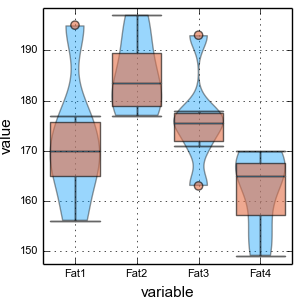

In [72]:
violin(sdonuts, :variable, :value, alpha=0.4, legend=false)
boxplot!(sdonuts, :variable, :value, alpha=0.6)

In [41]:
using GLM

In [76]:
anova = fit(GeneralizedLinearModel, value ~ variable, sdonuts, Normal(), IdentityLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Normal{Float64},GLM.IdentityLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: value ~ 1 + variable

Coefficients:
                 Estimate Std.Error  z value Pr(>|z|)
(Intercept)         172.0   4.10081  41.9429   <1e-99
variable - Fat2      13.0   5.79943   2.2416   0.0250
variable - Fat3       4.0   5.79943 0.689724   0.4904
variable - Fat4     -10.0   5.79943 -1.72431   0.0847


In [78]:
using RCall

In [130]:
by(sdonuts, :variable) do df
    DataFrame(
        P_AD = pvalue(OneSampleADTest(df[:value], Normal())),
        P_Shapiro = rcopy(R"shapiro.test($(df[:value]))")[symbol("p.value")]
    )
end

,variable,P_AD,P_Shapiro
1,Fat1,0.6176059803611285,0.7406352485668342
2,Fat2,0.6194216548282149,0.5926484972078393
3,Fat3,0.39409638619216925,0.6065677037767483
4,Fat4,0.27719288143949883,0.30967709220999107


In [128]:
R"""
library(car)
leveneTest(value ~ variable, $sdonuts)
"""

RCall.RObject{RCall.VecSxp}
Levene's Test for Homogeneity of Variance (center = median)
      Df F value Pr(>F)
group  3  0.3434 0.7942
      20               


In [87]:
R"oneway.test(value ~ variable, $sdonuts)"

RCall.RObject{RCall.VecSxp}

	One-way analysis of means (not assuming equal variances)

data:  value and variable
F = 7.4757, num df = 3.000, denom df = 10.953, p-value = 0.005353



In [88]:
R"""
modelo <- lm(value ~ variable, $sdonuts)
anova(modelo)
"""

RCall.RObject{RCall.VecSxp}
Analysis of Variance Table

Response: value
          Df Sum Sq Mean Sq F value   Pr(>F)   
variable   3 1636.5   545.5  5.4063 0.006876 **
Residuals 20 2018.0   100.9                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [91]:
R"coef(modelo)"

RCall.RObject{RCall.RealSxp}
 (Intercept) variableFat2 variableFat3 variableFat4 
         172           13            4          -10 


In [90]:
R"confint(modelo)"

RCall.RObject{RCall.RealSxp}
                   2.5 %     97.5 %
(Intercept)  163.4458541 180.554146
variableFat2   0.9026109  25.097389
variableFat3  -8.0973891  16.097389
variableFat4 -22.0973891   2.097389


#### Tabla de ANOVA

In [119]:
count = by(sdonuts, :variable, df -> nrow(df))
names!(count, [:variable, :n])

,variable,n
1,Fat1,6
2,Fat2,6
3,Fat3,6
4,Fat4,6


In [120]:
n = 6

6

In [122]:
g = 4

4

In [123]:
N = g * n

24

In [95]:
ȳ = mean(sdonuts[:value])

173.75

In [105]:
ȳᵢ = by(sdonuts, :variable, df -> mean(df[:value]))
names!(ȳᵢ, [:variable, :mean])

,variable,mean
1,Fat1,172.0
2,Fat2,185.0
3,Fat3,176.0
4,Fat4,162.0


In [114]:
datos = join(sdonuts, ȳᵢ, on=:variable)
head(datos, 10)

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in PooledDataVecs at /home/dzea/.julia/v0.4/DataArrays/src/pooleddataarray.jl:616
 in join at /home/dzea/.julia/v0.4/DataFrames/src/abstractdataframe/join.jl:202
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /home/dzea/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /home/dzea/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[114], in expression starting on line 1


,variable,value,mean
1,Fat1,164.0,172.0
2,Fat1,172.0,172.0
3,Fat1,168.0,172.0
4,Fat1,177.0,172.0
5,Fat1,156.0,172.0
6,Fat1,195.0,172.0
7,Fat2,178.0,185.0
8,Fat2,191.0,185.0
9,Fat2,197.0,185.0
10,Fat2,182.0,185.0


In [118]:
SSW = sum((datos[:value] .- datos[:mean]).^ 2) # sum of squares within

2018.0

In [121]:
SSB = n * sum((ȳᵢ[:mean] .- ȳ).^2) # sum of squares between

1636.5

In [124]:
F = (SSB/(g-1))/(SSW/(N-g))

5.406342913776015

In [125]:
using HypothesisTests

In [127]:
pvalue(FDist(g-1,N-g), F, tail=:right)

0.006875947754735093